# How to vectorize an `scikit-learn` transformer over a `numpy` array?

In this short post, I show how to vectorize an [`scikit-learn`](https://scikit-learn.org/stable/) transformer over a [`numpy`](https://numpy.org/doc/stable/) array. That is, how to apply a transformer along a specific axes of a `numpy` array. I have found this to be particularly useful when working with output sample posterior distributions from a bayesian model where I want to apply a transformer to each sample. This is not particularly difficult, but I always forget how to do it, so I thought I would write it down once and for all 😄.

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.preprocessing import FunctionTransformer
from numpy.random import RandomState

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

We generate a synthetic data set using the [`make_circles`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function from `scikit-learn`.


[Text(0.5, 1.0, 'Raw Data')]

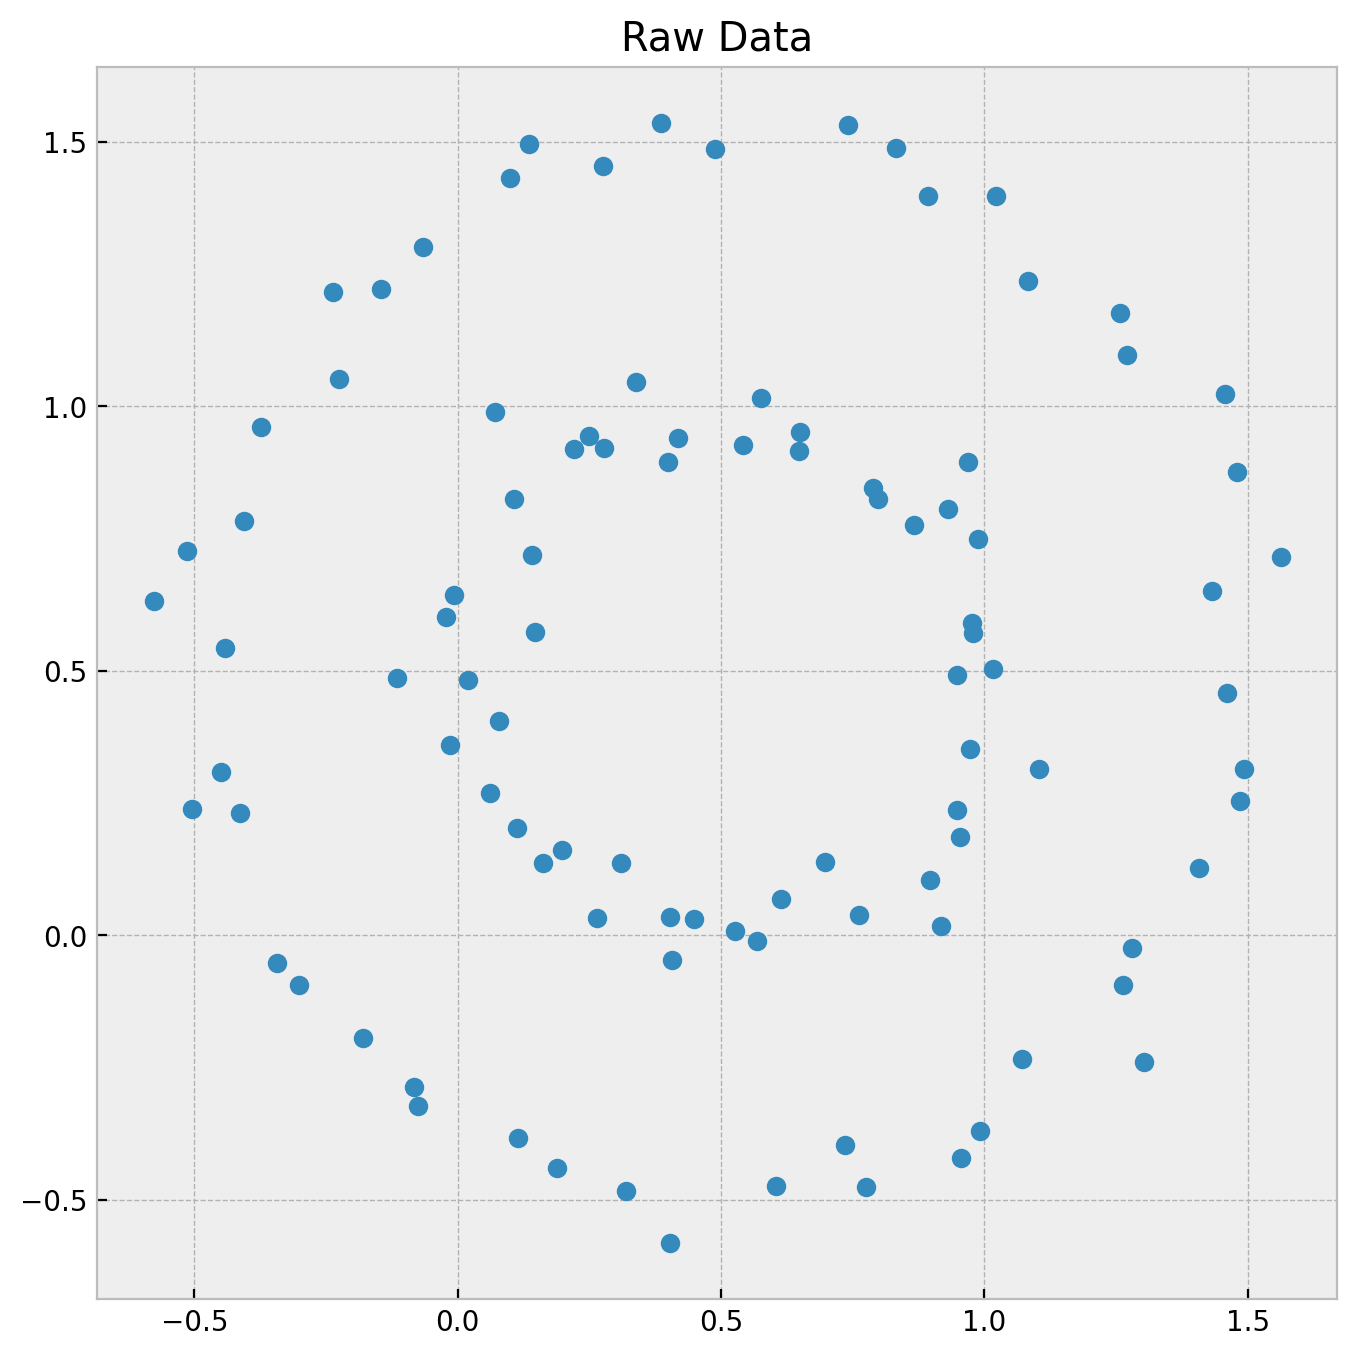

In [2]:
random_state = RandomState(seed=42)

x, _ = make_circles(n_samples=100, factor=0.5, noise=0.05, random_state=random_state)
x = x + 0.5

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x[:, 0], x[:, 1], "o", c="C0")
ax.set(
    title="Raw Data",
)


Let's see the dimensions of our circles data set.

In [3]:
x.shape

(100, 2)

Next, we generate another synthetic data set on which we have a bunch of these circles indexed by vectors in a `numpy` array

In [4]:
n = 6

z = np.array(
    [
        [make_circles(n_samples=(60, 60), random_state=random_state)[0] + i * 0.8]
        for i in range(n)
    ]
)

z.shape

(6, 1, 120, 2)

We can visualize the data set by coloring each circles subset according to the index of the array.

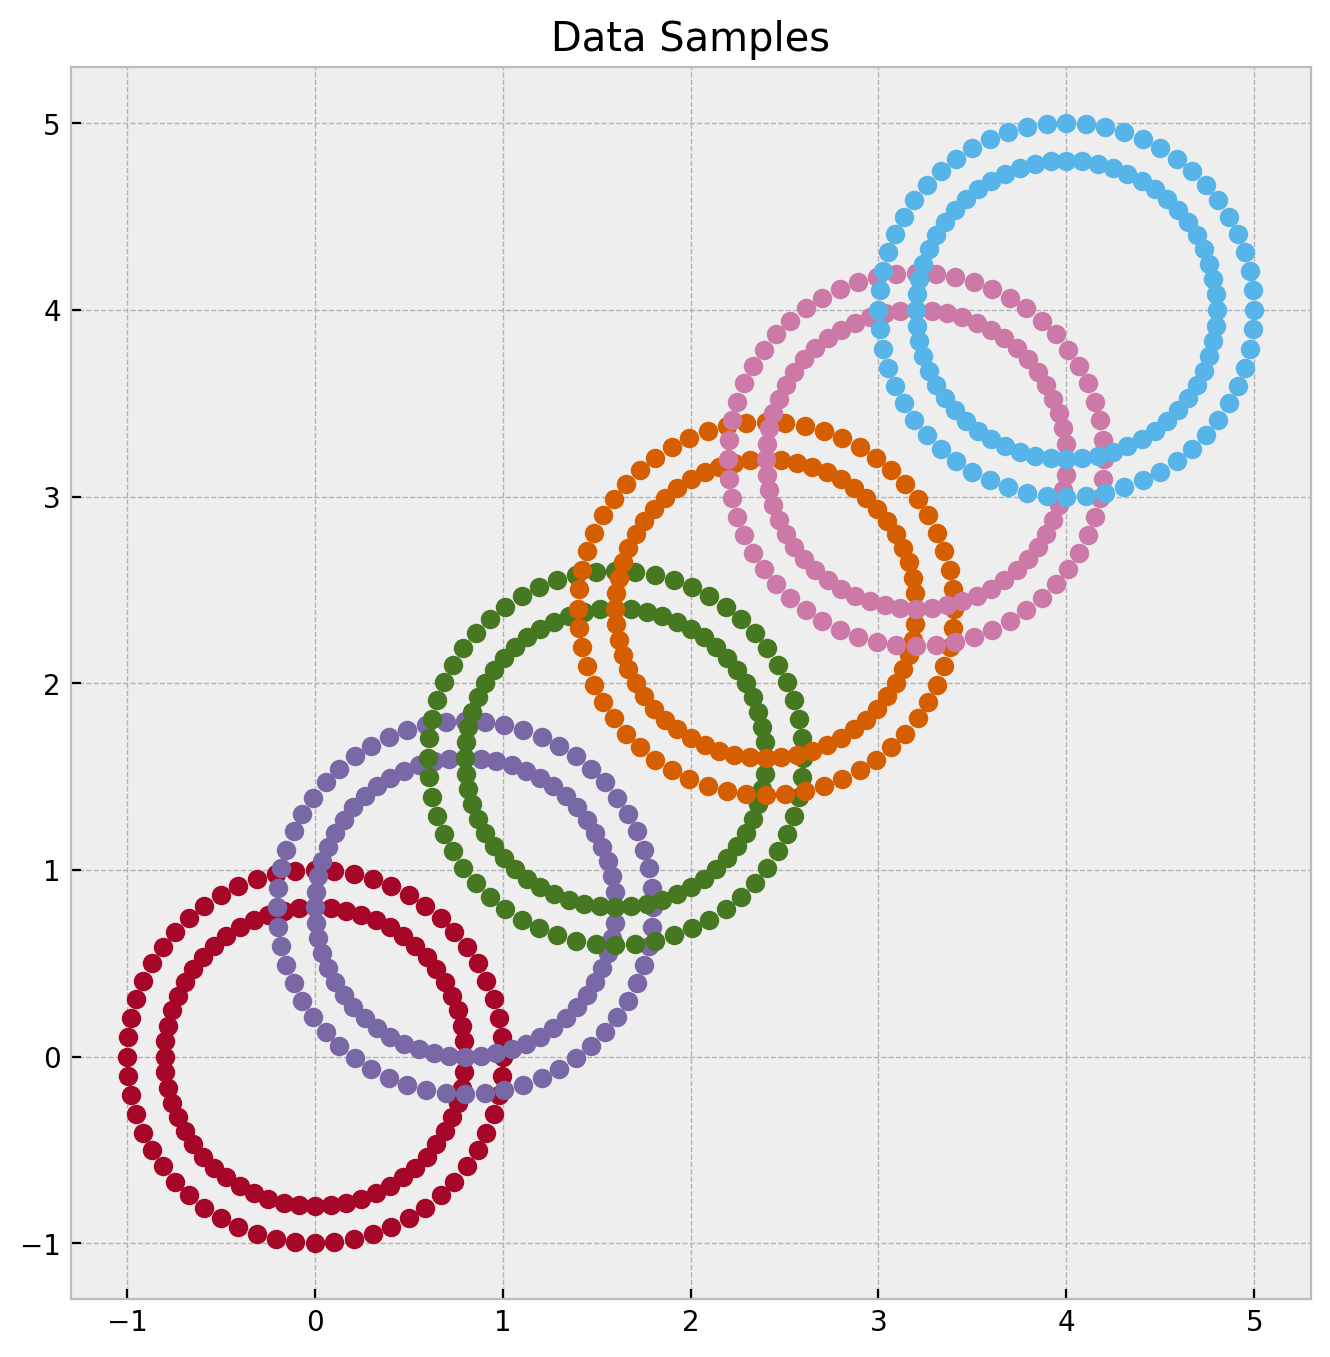

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(n):
    ax.plot(z[i, :, :, 0], z[i, :, :, 1], "o", c=f"C{i + 1}")
    ax.set(
        title="Data Samples",
    )

## Define Transformer

We specify a simple custom transformer which maps any non-zero vector to the unit circle by normalizing it.

In [6]:
circle_transformer = FunctionTransformer(
    func=lambda x: x / np.linalg.norm(x, axis=1)[..., None]
)
x_circle = circle_transformer.fit_transform(x)


We can plot the transformed data set.

[Text(0.5, 1.0, 'Transformed Data (projected onto unit circle)')]

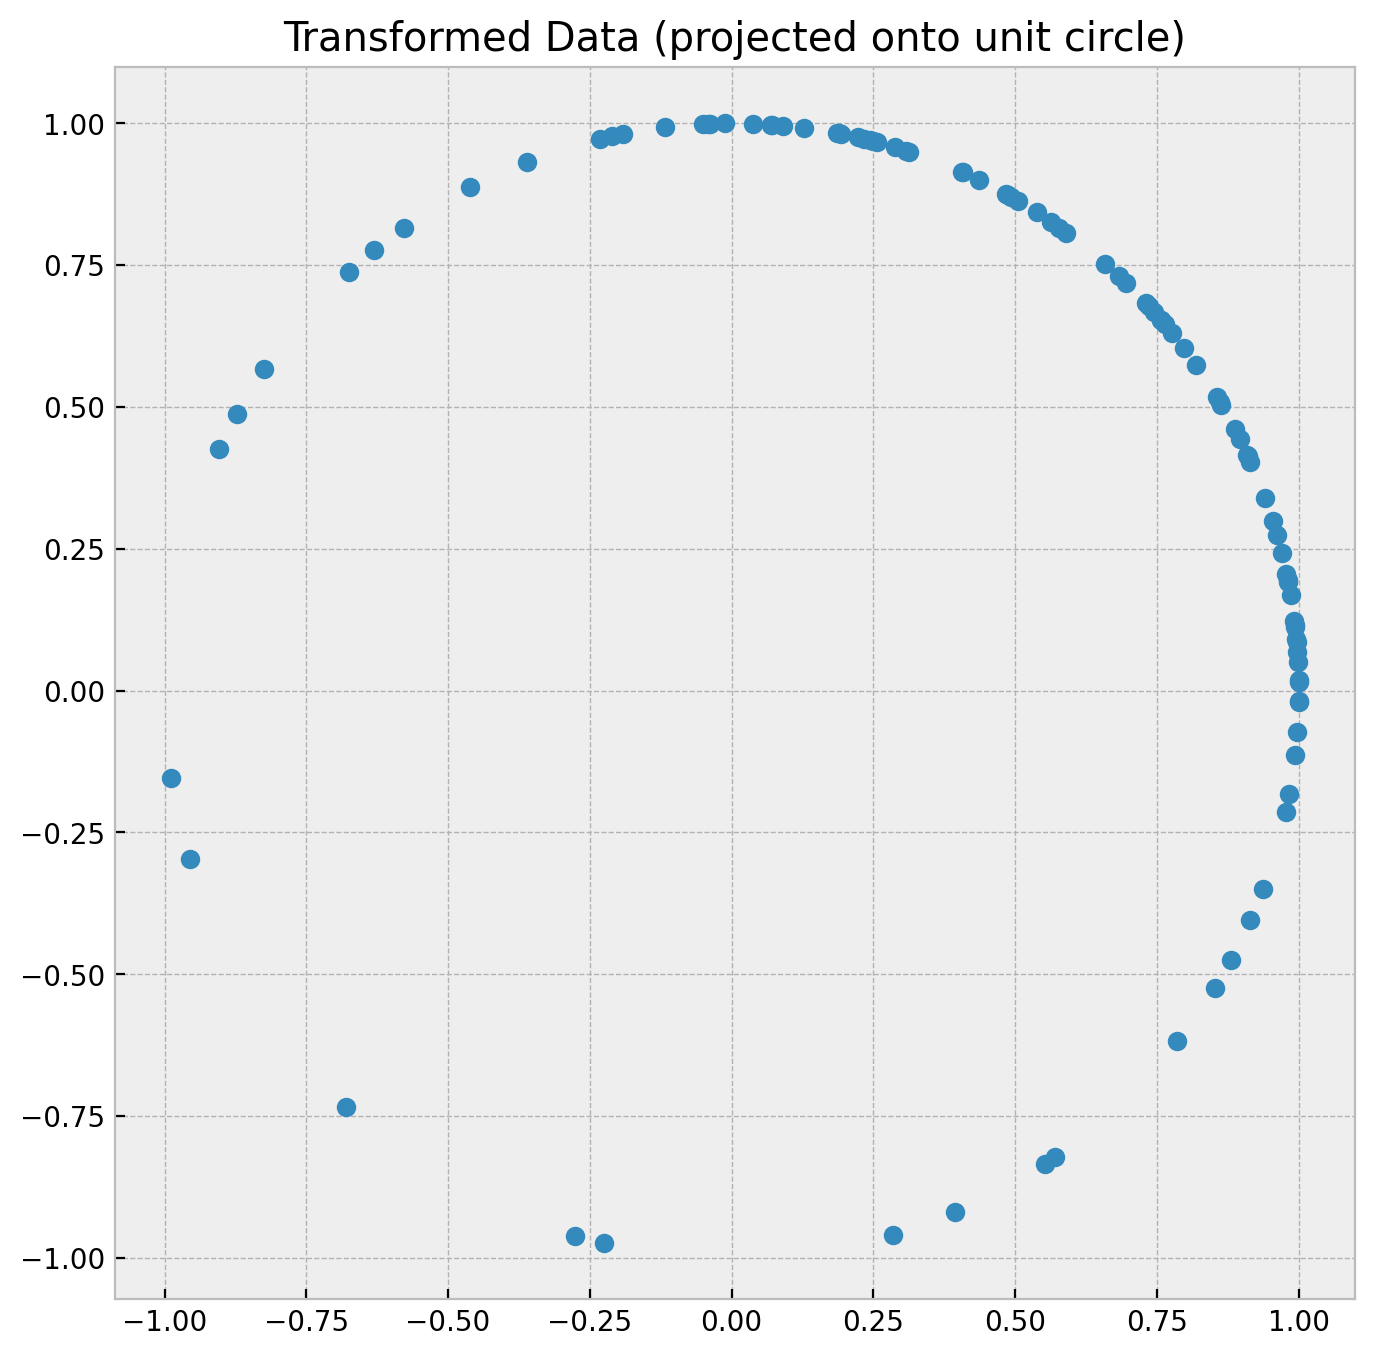

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x_circle[:, 0], x_circle[:, 1], "o", c="C0")
ax.set(
    title="Transformed Data (projected onto unit circle)",
)

## Vectorize Transformer

First let's see what happens if we apply the transformer to the entire array.

In [8]:
try:
    circle_transformer.transform(z)
except ValueError as e:
    print(f"ValueError: {e}")


ValueError: operands could not be broadcast together with shapes (6,1,120,2) (6,120,2,1) 


One could try to move some dimensions around:

In [9]:
np.moveaxis(a=z, source=[1], destination=[3]).shape

(6, 120, 2, 1)

In [10]:
try:
    circle_transformer.transform(np.moveaxis(a=z, source=[1], destination=[3]))
except ValueError as e:
    print(f"ValueError: {e}")

ValueError: operands could not be broadcast together with shapes (6,120,2,1) (6,2,1,1) 


But things do not seem to work 😒. The problem is that the transformer does not understand how to brodcast the transformation over the array. We need to tell it how to do it. We can do this by using the [`np.vectorize`](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) function.

In [11]:
vectorized_circle_transformer = np.vectorize(
    pyfunc=circle_transformer.transform,  # <- the function to vectorize
    excluded=[2, 3],  # <- the axes to exclude from the vectorization
    signature="(m, n) -> (m, n)",  # <- the signature of the function (input and output matrices)
)


Let's apply the vectorized transformer to the entire array.

In [12]:
z_circle = vectorized_circle_transformer(z)

z.shape

(6, 1, 120, 2)

Yay! It works! 🎉

Finally, we can plot the transformed data set.

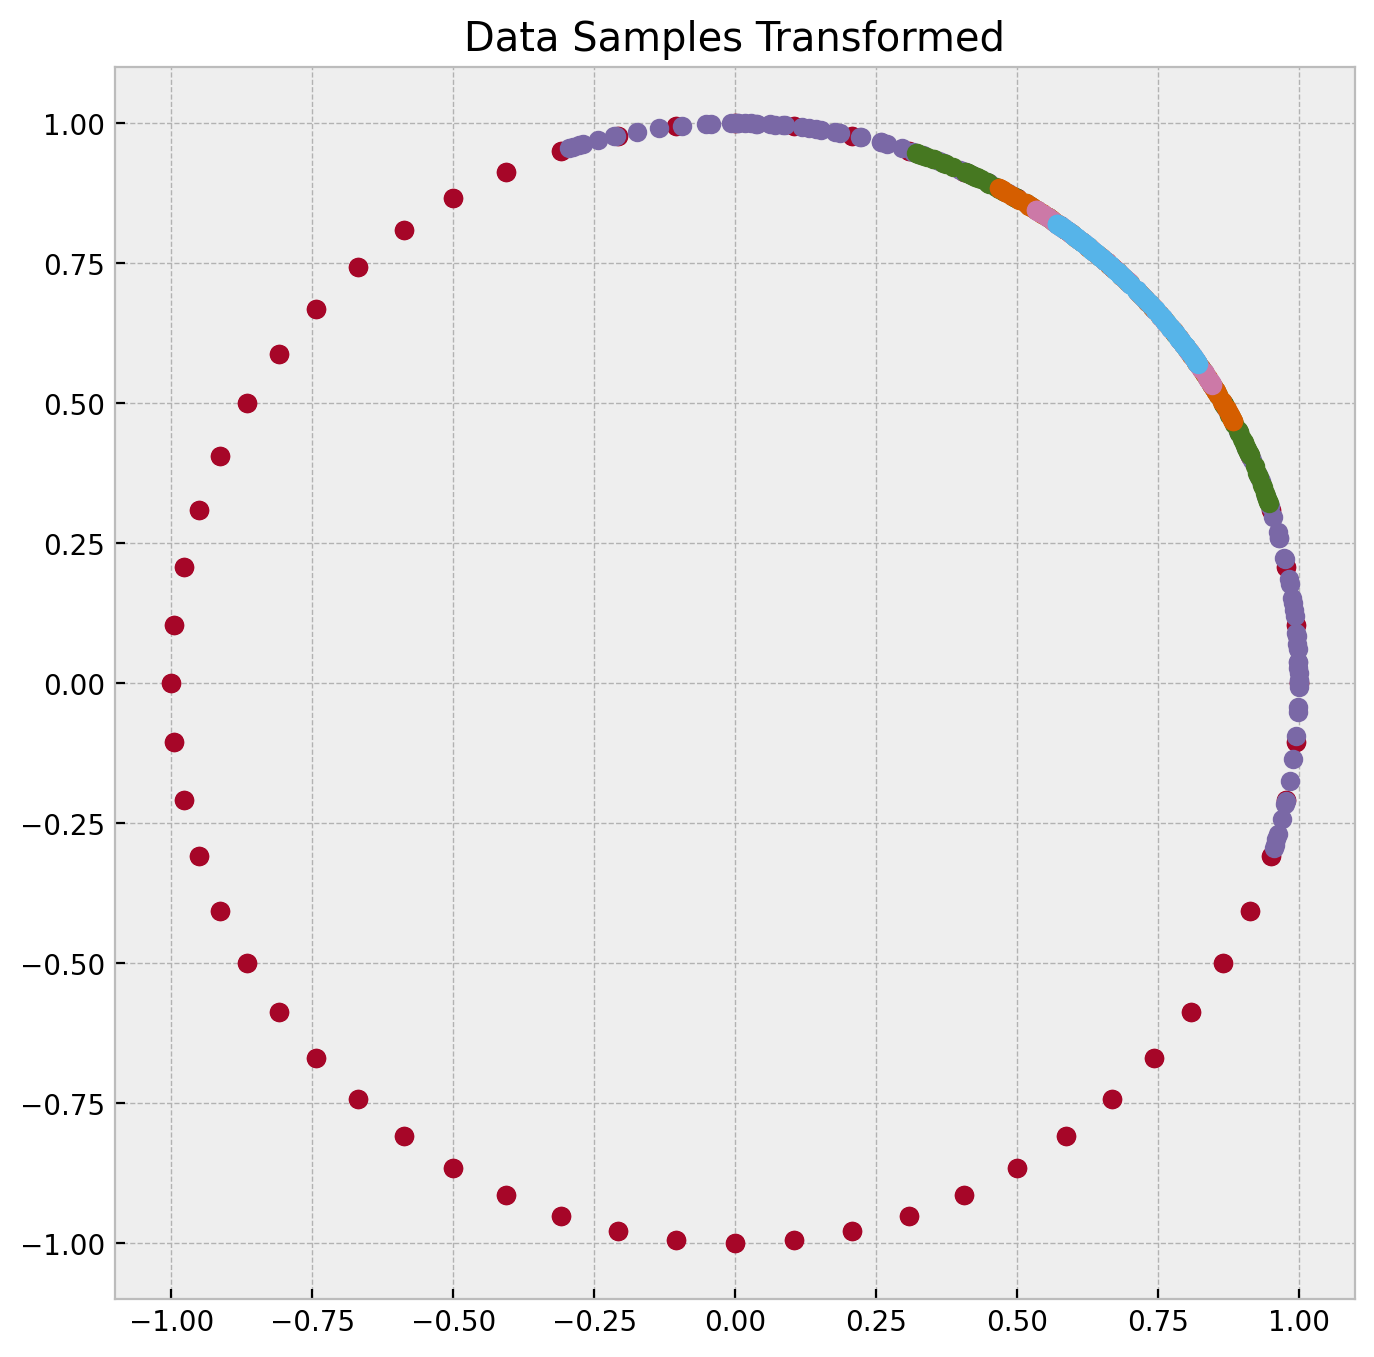

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(n):
    ax.plot(z_circle[i, :, :, 0], z_circle[i, :, :, 1], "o", c=f"C{i + 1}")
    ax.set(
        title="Data Samples Transformed",
    )

As expected all the points are mapped to the unit circle centered at the origin.